# Loan Application Study

## Table of Contents
- [Introduction](#intro)
- [Getting Aggregations from Previous Dataset](#prev)
- [Working with All Applications (Previous & Current)](#all)
    - [Data Wrangling](#wrangling)
    - [Exploratory Data Analysis](#eda)
    - [Conclusion of Analysis](#conclusions)
    - [Modeling](#modeling)



<a id='introduction'></a>
## Introduction
> **Business Overview:**
The business revolves around providing financial assistance to individuals or businesses in the form of loans.\
When someone applies for a loan, they are requesting a specific amount of money to be lent to them for a defined purpose.\
The lending institution evaluates the applicant's creditworthiness, risk profile, and financial stability to make informed decisions about granting or denying the loan.
>
> **Problem Statement:**
> The challenge is to predict whether an approved loan applicant will repay or default based on their provided information. Our objective is to develop a predictive model leveraging applicant data to enhance our ability to anticipate and manage potential risks associated with loan approvals. In particular, we place a strong emphasis on **optimizing the recall metric to effectively detect applicants more likely to default.**
> 
> **Data set:** You can find it [here](https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter?select=application_data.csv) on Kaggle. Consists of two files: current application data and previous applications data.
>
> **Strategy of using both datasets:**
> I will use the previous dataset only to get aggregated information about the applicant's history.\
Then I will merge it with the current application data to get the final dataset for analysis.

> ### Questions for Analysis we need to answer.
> 
> * **Studying of clients' demographics**
>
> * **Applicant's info**
>   1. How does the clients' Demographics such as the age related to the approval?
>   2. Is there a relation between income and the approval of loan?
>   3. How does the type of work or housing sitiuation related to the approval?
>
> * **Application's info**
>   1. Is there an optimal day of the week or time of day for applicants to submit their loan requests for higher approval chances?
>   2. Which most important documents that are necessary for the approval?

### Imports & Configrations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

curr_df = pd.read_csv('./Dataset/application_data.csv')
prev_df = pd.read_csv('./Dataset/previous_application.csv')

curr_df.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   LANDAREA_MODE  

In [2]:
curr_df.shape

(307511, 122)

In [3]:
prev_df.head(2)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP             NaN   
1           -164                    XNA                XAP   Unaccompanied   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   

     CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0    Country-wide                35         Connectivity         12.0   
1  Contact center                -1                  XNA         36.0   

  NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0           middle  POS mobile with interest            365243.0   
1       low_action          Cash X-Sell: low            365243.0   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0           -42.0                      300.0          -42.0             -37.0   
1          -134.0                      916.0       365243.0          365243.0   

   NFLAG_INSURED_ON_APPROVAL  
0                        0.0  
1                        1.0

In [4]:
prev_df.shape

(1670214, 37)

> Making the names of the columns in lower case for simplicity

In [5]:
curr_lower_case_columns_dict = {column: column.lower() for column in curr_df.columns}
prev_lower_case_columns_dict = {column: column.lower() for column in prev_df.columns}

curr_df.rename(columns=curr_lower_case_columns_dict, inplace=True)
prev_df.rename(columns=prev_lower_case_columns_dict, inplace=True)

curr_df.head(1)

sk_id_curr  target name_contract_type code_gender flag_own_car  \
0      100002       1         Cash loans           M            N   

  flag_own_realty  cnt_children  amt_income_total  amt_credit  amt_annuity  \
0               Y             0          202500.0    406597.5      24700.5   

   amt_goods_price name_type_suite name_income_type  \
0         351000.0   Unaccompanied          Working   

             name_education_type    name_family_status  name_housing_type  \
0  Secondary / secondary special  Single / not married  House / apartment   

   region_population_relative  days_birth  days_employed  days_registration  \
0                    0.018801       -9461           -637            -3648.0   

   days_id_publish  own_car_age  flag_mobil  flag_emp_phone  flag_work_phone  \
0            -2120          NaN           1               1                0   

   flag_cont_mobile  flag_phone  flag_email occupation_type  cnt_fam_members  \
0                 1           1           0        Laborers              1.0   

   region_rating_client  region_rating_client_w_city  \
0                     2                            2   

  weekday_appr_process_start  hour_appr_process_start  \
0                  WEDNESDAY                       10   

   reg_region_not_live_region  reg_region_not_work_region  \
0                           0                           0   

   live_region_not_work_region  reg_city_not_live_city  \
0                            0                       0   

   reg_city_not_work_city  live_city_not_work_city       organization_type  \
0                       0                        0  Business Entity Type 3   

   ext_source_1  ext_source_2  ext_source_3  apartments_avg  basementarea_avg  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   

   years_beginexpluatation_avg  years_build_avg  commonarea_avg  \
0                       0.9722           0.6192          0.0143   

   elevators_avg  entrances_avg  floorsmax_avg  floorsmin_avg  landarea_avg  \
0            0.0          0.069         0.0833          0.125        0.0369   

   livingapartments_avg  livingarea_avg  nonlivingapartments_avg  \
0                0.0202           0.019                      0.0   

   nonlivingarea_avg  apartments_mode  basementarea_mode  \
0                0.0           0.0252             0.0383   

   years_beginexpluatation_mode  years_build_mode  commonarea_mode  \
0                        0.9722            0.6341           0.0144   

   elevators_mode  entrances_mode  floorsmax_mode  floorsmin_mode  \
0             0.0           0.069          0.0833           0.125   

   landarea_mode  livingapartments_mode  livingarea_mode  \
0         0.0377                  0.022           0.0198   

   nonlivingapartments_mode  nonlivingarea_mode  apartments_medi  \
0                       0.0                 0.0            0.025   

   basementarea_medi  years_beginexpluatation_medi  years_build_medi  \
0             0.0369                        0.9722            0.6243   

   commonarea_medi  elevators_medi  entrances_medi  floorsmax_medi  \
0           0.0144             0.0           0.069          0.0833   

   floorsmin_medi  landarea_medi  livingapartments_medi  livingarea_medi  \
0           0.125         0.0375                 0.0205           0.0193   

   nonlivingapartments_medi  nonlivingarea_medi fondkapremont_mode  \
0                       0.0                 0.0   reg oper account   

   housetype_mode  totalarea_mode wallsmaterial_mode emergencystate_mode  \
0  block of flats          0.0149       Stone, brick                  No   

   obs_30_cnt_social_circle  def_30_cnt_social_circle  \
0                       2.0                       2.0   

   obs_60_cnt_social_circle  def_60_cnt_social_circle  days_last_phone_change  \
0                       2.0                       2.0                 -1134.0   

   flag_document_2  flag_document_3  flag_document_4  flag_document_5  

### Functions we will use

In [6]:
def get_unique_values(dataframe):
    """
    Getting the unique values for each column in the dataframe
    """
    for column in dataframe.columns:
        unique_values = dataframe[column].value_counts()
        print(f'Column: {column} \n{unique_values}\n\n')
        
        
def get_previous_status(row, threshold=0.1):
    """
    Returns the previous status as 'Good' = 1 or 'Bad' = -1 based on the approval and rejection rates
    Inputs:
        row: A row of the dataframe
        threshold: The threshold that cause giving 'Good' sign hard a bit. [Minimising the risk]
    
    Returns:
        1: If the previous status was good
        -1: If the previous status was bad
        0: If the previous status was neutral
    """
    
    status = row.approval_rate - row.rejection_rate
    
    if status > threshold:
        return 1
    elif 0 < status < threshold:
        return 0
    else:
        return -1

def get_percentage_of_missing(dataframe, sort=True):
    """
        Getting the percentage of missing values in the dataframe
        Input:
            dataframe
        Output:
            percentage: like .value_counts() but with column name and the corresponding % of missing value.
    """
    columns_with_missing_values = dataframe.loc[:, dataframe.isna().sum() > 0]
    percentages = (columns_with_missing_values.isna().sum() / dataframe.shape[0]) * 100
    
    if sort == True:
        percentages = percentages.sort_values(ascending=False)
        
    return percentages


def get_occupation_type(grouped_data, row):
    """
        Getting the most appearing job based on the organization and the education type
        [Encoding with other columns]
        
        Inpust:
            grouped_data: grouped data its:
                index is ==> (organization, education, occupation_type).
                value is ==> number of jobs.
                
            row: a row with data of the applicant's application
        Output:
            job: The most appearing job in case of the provided organization & education
    """
    changed = False
    if not pd.isnull(row.occupation_type): # If not missing value
        job = row.occupation_type
        
    else:
        organization = row.organization_type
        education    = row.name_education_type
        compination  = (organization, education)
        
        if compination in grouped_data.index: # if the compination of the organization and the education exists
            job = grouped_data[(organization, education)].idxmax()
            
        else: # if not, take based only the organization
            job = grouped_data[organization].sort_values(ascending=False).reset_index().occupation_type[0]
            
    return job


def get_numbers(string):
    numbers = ''
    for letter in string:
        if letter.isdigit():
            numbers += letter
    return numbers


def cutting(x_train, x_test, columns):
    """
        Making cutting on continuos columns
        the bins comes from the train set only [To avoide data leakage]
    """
    train, test = x_train.copy(), x_test.copy()
    
    labels = [0, 1, 2, 3]
    for column in columns:
        minimum, low, moderate, high, maximum = train[column].describe()[3:].values
        
        , 10bins = [minimum - 1e-10, low,moderate, high, maximum + 1e-10]
        new_column_trian = pd.cut(train[column], bins=bins, labels=labels)
        new_column_test = pd.cut(test[column], bins=bins, labels=labels)
        
        
        train[column] = new_column_trian
        test[column]  = new_column_test
    
    return train, test
    
################## Plotting Functions ####################33

color_plate_1 = ['#547053', '#789d83', '#b78d37', '#604422', '#274532', '#905626', '#304f4d', '#7d888e', '#c8c6a9']
color_plate_2 = ['#1d4c76', '#1d2746', '#7b96b2', '#6381aa', '#9d8aab', '#85bee6', '#31312a', '#58606f', '#bbb7bf']
maps = ['tab20b']


def plot_categorical_pie(dataframe, column, labels=None, title=None):
    """
    SUMMERY: Function to plot pie chart for the categories on specific column.
    
    Inputs:
        dataframe: (pd.DataFrame) the DataFrame containing the data.
        column: (str) column name for which to chart the pie chart.
        title: (str) title of the pie chart.
        
    Output:
        Displaying the pie chart.
    """
    values = dataframe[column].value_counts().values
    
    if labels is None:
        labels = dataframe[column].value_counts().index.tolist()
        
    if title is None:
        title = f'Distribution of {column}'
    
    
    sns.set()
    colors = color_plate_2[:len(labels)]
    # fig = plt.figure(figsize =(5, 7))
    plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%', textprops={'color': "w"})
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.show()
    
def boxplot(dataframe, column_name):
    """
        Plotting the distribution of a column with boxplot
    """
    
    sns.boxplot(x=column_name, data=dataframe);

    # Calculate and plot the mean as a red point
    mean_value = dataframe[column_name].mean()
    plt.plot(mean_value, 0, marker='o', markersize=8, color='red', label='Mean');
    plt.title(f'Distribution of the {column_name}')
    plt.legend();
    
def get_propotions(DataFrame, column_name, target='target'):
    """
        SUMMERY:
            TO GIVE PROPOTIONS OF THE VALUES IN THE COLUMNS.
        TAKE:
            column_name: (str) for the column we need to get propotions on it.
            DataFrame: (DataFrame) for the data frame we need to make propotions on it.
            target(optional): if not passed, this will get propotions between the column & target
                              if passed any column this will get propotions between these 2 columns
                              Actually the 2 options are [target, prev_status]
        RETURN:
            propotions
     """ 
    
    total_values_for_each_category = DataFrame.groupby([column_name])[target].count()
    
    # Getting the count of all who are repaied for each category and count of all who didn't in each category.
    values_of_repaying = DataFrame.groupby([column_name, target])[target].count()
    
    # To be fair we do not use ValuesFor_Show_noShow but we divide it by the TotalValues
    # as our data have different numbers of rows for each category .. so to be fair we divide each 
    # count of patients who showed up in category X by the total number of patients in this category.
    propotions = values_of_repaying / total_values_for_each_category
    
    return propotions


def PlotPropotions(propotions, rot=90):
    # Propotions come from get_propotion function.
    color_map = np.random.choice(maps)
    
    labels = propotions.unstack().index.tolist()
    column1, column2 = propotions.keys().names
    
    propotions.unstack().plot(kind='bar', cmap=color_map);
    plt.ylabel('Avg')
    plt.xlabel('');
    plt.title(f'{column1} & {column2}', fontsize=15, fontweight='bold')
    
    if column2 == 'target': 
        plt.legend(labels=['Repayers', 'Defaulters'], fontsize=14, bbox_to_anchor=(1.05, 0.7));
    else:
        plt.legend(fontsize=14, bbox_to_anchor=(1.05, 0.7));
      
    plt.xticks(range(len(labels)), labels, rotation=rot);

<a id='previous-dataset'></a>

## Getting aggregations from previous dataset

In [7]:
prev_df.groupby(['sk_id_curr', 'sk_id_prev']).count()['name_contract_type'].head()

sk_id_curr  sk_id_prev
100001      1369693       1
100002      1038818       1
100003      1810518       1
            2396755       1
            2636178       1
Name: name_contract_type, dtype: int64

> There are many current applications that have previous applications.
> 
> For this reason we will aggregate the previous applications data to get the insights we need and then merge it with the current applications data.

In [8]:
# Dataframe we will save our aggregated data to
agg_df = pd.DataFrame()

> **For approved applications:**
> 1. The average amount of credit taken by the applicant.
> 2. The average amount of annuity approved for the applicant.

> **Note**: for approved only due to get intiuation about how much the applicant can pay back.

> Calculating the avg amout of credit taken by the applicant
> 
> **amt_application** -> is the amount of credit requested by the applicant.\
> **amt_credit** -> is the amount of credit granted to the applicant.
> 
> **Notice**: So, we will use amt_creadit for approved applications.

In [9]:
approved_df = prev_df.query('name_contract_status == "Approved"')

approved_df = approved_df.groupby('sk_id_curr').agg({
    'amt_credit': 'mean',
    'amt_annuity': 'mean',
    })

In [10]:
approved_df.head(2)

amt_credit  amt_annuity
sk_id_curr                         
100001         23787.0     3951.000
100002        179055.0     9251.775

> **For only approved and refused applications as our target is to approve or refuse the loan:**

In [11]:
grouped_data_approval_refusion = prev_df.groupby(['sk_id_curr', 'name_contract_status']).count().unstack(fill_value=0)['sk_id_prev']

agg_df['approval_rate'] = grouped_data_approval_refusion['Approved'] / grouped_data_approval_refusion.sum(axis=1)
agg_df['rejection_rate'] = grouped_data_approval_refusion['Refused'] / grouped_data_approval_refusion.sum(axis=1)

agg_df['prev_status'] = agg_df.apply(lambda row: get_previous_status(row), axis=1)

In [12]:
# No need for the approval and rejection rates anymore
agg_df.drop(columns=['approval_rate', 'rejection_rate'], inplace=True)

# Merging the 2 aggregation datasets
agg_df = approved_df.merge(agg_df, on='sk_id_curr', how='inner')

In [13]:
# Renaming the columns
agg_df.rename(columns={'amt_credit': 'prev_avg_approved_credit', 'amt_annuity': 'prev_avg_approved_annuity'}, inplace=True)

In [14]:
agg_df.sample(5)

prev_avg_approved_credit  prev_avg_approved_annuity  prev_status
sk_id_curr                                                                  
257207                      92769.75                 12263.2425           -1
206988                      21357.00                  5006.0700           -1
283282                     106103.25                  8643.6900            1
364812                     158265.00                  9834.0075           -1
181097                      33376.50                  9508.9500            1

In [15]:
# The Nan values here will be error in data, so we will drop them
agg_df.isna().sum()

prev_avg_approved_credit     0
prev_avg_approved_annuity    2
prev_status                  0
dtype: int64

In [16]:
agg_df.dropna(inplace=True)
agg_df.isna().any()

prev_avg_approved_credit     False
prev_avg_approved_annuity    False
prev_status                  False
dtype: bool

> Now we finished getting features we need from the previous data, Now lets add these aggreagated values with the current dataset

In [17]:
df = curr_df.merge(agg_df, on='sk_id_curr', how='left')

## Working with all the applications [prev & curr]

### Data Assessing

In [18]:
df.head(2)

sk_id_curr  target name_contract_type code_gender flag_own_car  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  flag_own_realty  cnt_children  amt_income_total  amt_credit  amt_annuity  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   amt_goods_price name_type_suite name_income_type  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   

             name_education_type    name_family_status  name_housing_type  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   region_population_relative  days_birth  days_employed  days_registration  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   days_id_publish  own_car_age  flag_mobil  flag_emp_phone  flag_work_phone  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   flag_cont_mobile  flag_phone  flag_email occupation_type  cnt_fam_members  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   

   region_rating_client  region_rating_client_w_city  \
0                     2                            2   
1                     1                            1   

  weekday_appr_process_start  hour_appr_process_start  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   

   reg_region_not_live_region  reg_region_not_work_region  \
0                           0                           0   
1                           0                           0   

   live_region_not_work_region  reg_city_not_live_city  \
0                            0                       0   
1                            0                       0   

   reg_city_not_work_city  live_city_not_work_city       organization_type  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   

   ext_source_1  ext_source_2  ext_source_3  apartments_avg  basementarea_avg  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   

   years_beginexpluatation_avg  years_build_avg  commonarea_avg  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   elevators_avg  entrances_avg  floorsmax_avg  floorsmin_avg  landarea_avg  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   livingapartments_avg  livingarea_avg  nonlivingapartments_avg  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   nonlivingarea_avg  apartments_mode  basementarea_mode  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   years_beginexpluatation_mode  years_build_mode  commonarea_mode  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   elevators_mode  entrances_mode  floorsmax_mode  floorsmin_mode  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   landarea_mode  

> Checking for duplicated documets

In [19]:
print(f'Number of duplicats in applications is: {int(df.duplicated().any())}')

Number of duplicats in applications is: 0


> Checking how much new documents that not have history

In [20]:
print(f'There are {df.prev_status.isna().sum()} new docs that are not having history')

There are 17448 new docs that are not having history


> Missing data in columns

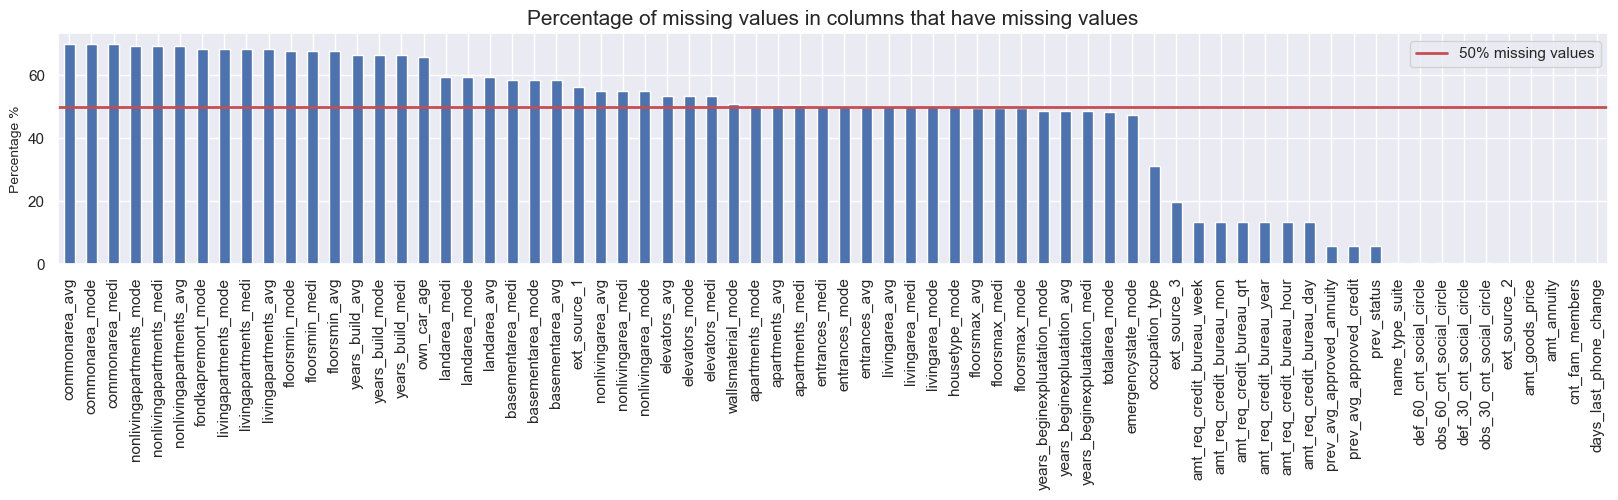

In [21]:
percentage_per_column = get_percentage_of_missing(df)

percentage_per_column.plot(kind='bar', figsize=(20, 3));
plt.axhline(50, c='r', linewidth=2, label='50% missing values');
plt.title('Percentage of missing values in columns that have missing values', fontsize=15);
plt.ylabel('Percentage %', fontsize=10);
plt.legend();

> Columns with more than 50% missing values will be dropped.

#### Checking categorical columns
> 
> * We will take all the not numeric featuers.
> 
> * We will add to them all the numeric features that has a # unique values < threshould = 8.
>
>   * **Note**: Threshould chosen to `8` after considering the columns for the `name_income_type` column

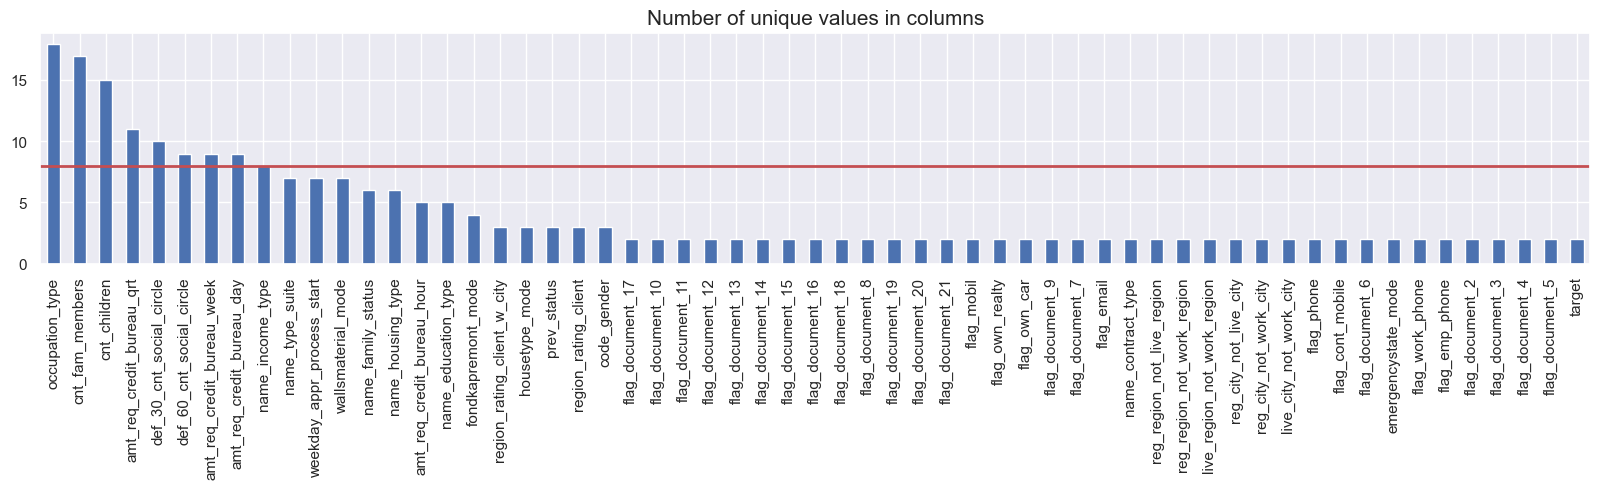

In [22]:
threshould = 8
suggested_categorical_columns = df.loc[:, df.nunique() < 24].nunique().sort_values(ascending=False)

suggested_categorical_columns.plot(kind='bar', figsize=(20, 3));
plt.axhline(threshould, c='r', linewidth=2);
plt.title('Number of unique values in columns', fontsize=15);

> * Most categorical columns are `Binary`.
> * Columns under the line considered categorical.
> * All coulumns above the line and with `string` data type considered categorical.

In [23]:
threshoulded_columns = df.loc[:, (df.nunique().sort_values(ascending=False) < threshould)].columns
string_columns = df.select_dtypes(exclude=np.number).columns

categorical_columns = list(set(list(threshoulded_columns) + list(string_columns)))

In [24]:
categorical_df = df.loc[:, categorical_columns]

> Checking missing values in categorical columns

In [25]:
get_percentage_of_missing(categorical_df)

fondkapremont_mode            68.386172
wallsmaterial_mode            50.840783
housetype_mode                50.176091
emergencystate_mode           47.398304
occupation_type               31.345545
amt_req_credit_bureau_hour    13.501631
prev_status                    5.673943
name_type_suite                0.420148
dtype: float64

> `fondkapremont_mode`, `wallsmaterial_mode`, `housetype_mode`, `emergencystate_mode` will be droped as they have missing values ~ 50%.
> 
> `prev_status` column null values comes from not having a history, So we will handel it with `0` as not approved or rejected before.
> 
> `name_type_suite` missing values will replaced with `Unaccompanied` as `the mode`.

> Checking the unique values in categorical columns

In [26]:
get_unique_values(categorical_df)

Column: name_education_type 
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: name_education_type, dtype: int64


Column: live_city_not_work_city 
0    252296
1     55215
Name: live_city_not_work_city, dtype: int64


Column: flag_document_8 
0    282487
1     25024
Name: flag_document_8, dtype: int64


Column: flag_work_phone 
0    246203
1     61308
Name: flag_work_phone, dtype: int64


Column: flag_document_6 
0    280433
1     27078
Name: flag_document_6, dtype: int64


Column: flag_email 
0    290069
1     17442
Name: flag_email, dtype: int64


Column: reg_city_not_work_city 
0    236644
1     70867
Name: reg_city_not_work_city, dtype: int64


Column: amt_req_credit_bureau_hour 
0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: amt_req_credit_bureau_hour, dtype: int64


Column: flag_document_17 
0    3

There are values that is not make sense and just added to indicate a null such as:
> * **code_gender** has `XNA` value.
> * **name_family_status** has `Unknown` value.
> * **organization_type** has `XNA` value also.

#### Checking numerical columns

In [27]:
numeric_df = df.select_dtypes(np.number)
numeric_df.describe()

sk_id_curr         target   cnt_children  amt_income_total  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         amt_credit    amt_annuity  amt_goods_price  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       region_population_relative     days_birth  days_employed  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       days_registration  days_id_publish    own_car_age     flag_mobil  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       flag_emp_phone  flag_work_phone  flag_cont_mobile     flag_phone  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          flag_email  cnt_fam_members  region_rating_client  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       region_rating_client_w_city  hour_appr_process_start  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

> **Noticed** Columns of days such as `days_birth`, `days_registration`, etc, are in **Negative** values.

#### Checking the output

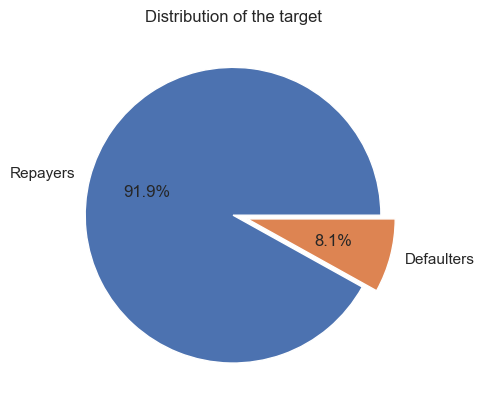

In [28]:
value_counts = df.target.value_counts()

labels = ['Repayers', 'Defaulters']
explode = (0, 0.1)
plt.pie(value_counts, labels=labels, explode=explode, autopct='%1.1f%%');
plt.title('Distribution of the target');

> The data is heighly biased
>
> We could use Tree based algorithms with class weight to handel this problem.

### Data Cleaning

#### Operations on whole dataset.
>
> The transformation values will come from only the train set, then applied to both train, test. `[Handling Data Leakage]`

> First lets give `0` for all null values in the columns come from the previous docs.

In [29]:
df.iloc[:, -3:].isna().sum()

prev_avg_approved_credit     17448
prev_avg_approved_annuity    17448
prev_status                  17448
dtype: int64

In [30]:
df.iloc[:, -3:] = df.iloc[:, -3:].fillna(0)
df.iloc[:, -3:].isna().sum()

prev_avg_approved_credit     0
prev_avg_approved_annuity    0
prev_status                  0
dtype: int64

> lets drop all columns with % missing values >= 47%
> 
> As the columns that have missing perc between 50% to 47% are columns of the same info about the bulding the applicant lives in.

In [31]:
missing_percentages = get_percentage_of_missing(df)
missing_greater_47 = missing_percentages[missing_percentages >= 47].index.tolist()

In [32]:
df.drop(columns=missing_greater_47, inplace=True)

df.head(2)

sk_id_curr  target name_contract_type code_gender flag_own_car  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  flag_own_realty  cnt_children  amt_income_total  amt_credit  amt_annuity  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   amt_goods_price name_type_suite name_income_type  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   

             name_education_type    name_family_status  name_housing_type  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   region_population_relative  days_birth  days_employed  days_registration  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   days_id_publish  flag_mobil  flag_emp_phone  flag_work_phone  \
0            -2120           1               1                0   
1             -291           1               1                0   

   flag_cont_mobile  flag_phone  flag_email occupation_type  cnt_fam_members  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   

   region_rating_client  region_rating_client_w_city  \
0                     2                            2   
1                     1                            1   

  weekday_appr_process_start  hour_appr_process_start  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   

   reg_region_not_live_region  reg_region_not_work_region  \
0                           0                           0   
1                           0                           0   

   live_region_not_work_region  reg_city_not_live_city  \
0                            0                       0   
1                            0                       0   

   reg_city_not_work_city  live_city_not_work_city       organization_type  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   

   ext_source_2  ext_source_3  obs_30_cnt_social_circle  \
0      0.262949      0.139376                       2.0   
1      0.622246           NaN                       1.0   

   def_30_cnt_social_circle  obs_60_cnt_social_circle  \
0                       2.0                       2.0   
1                       0.0                       1.0   

   def_60_cnt_social_circle  days_last_phone_change  flag_document_2  \
0                       2.0                 -1134.0                0   
1                       0.0                  -828.0                0   

   flag_document_3  flag_document_4  flag_document_5  flag_document_6  \
0                1                0                0                0   
1                1                0                0                0   

   flag_document_7  flag_document_8  flag_document_9  flag_document_10  \
0                0                0                0                 0   
1                0                0                0                 0   

   flag_document_11  flag_document_12  flag_document_13  flag_document_14  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   

   flag_document_15  flag_document_16  flag_document_17  flag_document_18  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   

   flag_document_19  flag_document_20  flag_document_21  \
0            

#### Operations [transformations] on the train set
> All we do in the train will be applied also for test seperately

In [33]:
df_train,  df_test = train_test_split(df.drop(columns=['sk_id_curr']), stratify=df.target, test_size=0.2, random_state=42)

##### Cleaning columns with `object` or `string` data types.

**Handling notes from data assessing**

> Handling with not good values in some columns that indicates null

In [34]:
# Converting them to null values to handel them as nulls
df_train.code_gender[df_train.code_gender == 'XNA'] = np.nan
df_test.code_gender[df_test.code_gender == 'XNA'] = np.nan

df_train.name_family_status[df_train.name_family_status == 'Unknown'] = np.nan
df_test.code_gender[df_test.name_family_status == 'Unknown'] = np.nan

# We will not do this now, as we will need this column be not having nulls
# to get another column values based on it.
df_train.organization_type[df_train.organization_type == 'XNA'] = np.nan
df_test.organization_type[df_test.organization_type == 'XNA'] = np.nan

> We let the `code_gender`, `name_family_status`, `name_type_suite` to be handeled with other categorical `numerical` columns with mode.

> **Handling the `occupation_type` column**
> * Using the `organization_type` & `name_education_type` columns **That have no null values** and **related to work** to fill missing values in the `occupation_type` column.
>   * But first lets drop all rows with XNA organization type.
> * Only used train set to create the source data of imputation, not the whole dataset `[Data Leakage Handling]`.

In [35]:
df_train.dropna(subset=['organization_type'], inplace=True)
df_test.dropna(subset=['organization_type'], inplace=True)

In [36]:
grouped_data = df_train.groupby(['organization_type', 'name_education_type', 'occupation_type']).count()['name_contract_type']
grouped_data.head()

organization_type  name_education_type  occupation_type      
Advertising        Academic degree      Drivers                   1
                   Higher education     Accountants              15
                                        Core staff               54
                                        Drivers                   1
                                        High skill tech staff     7
Name: name_contract_type, dtype: int64

In [37]:
# Befor
print(f'Befor, The job of the applicant no 8 is: {df_train.occupation_type.iloc[9]}')

Befor, The job of the applicant no 8 is: nan


In [38]:
# applay the data from only the train set into train, test sets.
df_train['occupation_type'] = df_train.apply(lambda row: get_occupation_type(grouped_data, row), axis=1)
df_test['occupation_type'] = df_test.apply(lambda row: get_occupation_type(grouped_data, row), axis=1)

In [39]:
print(f'After, The job of the applicant no 8 is: {df_train.occupation_type.iloc[9]}')

After, The job of the applicant no 8 is: Laborers


##### Cleaning existing columns, columns with `numeric` data types.

**Handling the noticed notes on the `days columns` we took in the data assessing**

> They have **Negative** values.

In [40]:
days_columns = ['days_birth', 'days_id_publish', 'days_registration', 'days_employed', 'days_last_phone_change']
df_train[days_columns].head(1)

days_birth  days_id_publish  days_registration  days_employed  \
181648      -12298            -4670            -6378.0           -946   

        days_last_phone_change  
181648                     0.0

In [41]:
df_train[days_columns] = df_train[days_columns].abs()
df_test[days_columns] = df_test[days_columns].abs()

df_train[days_columns].head(1)

days_birth  days_id_publish  days_registration  days_employed  \
181648       12298             4670             6378.0            946   

        days_last_phone_change  
181648                     0.0

> Converting the number of days into number of years in the `days_birth` to be significant in analysis, renaming it to `age`

In [42]:
df_train.days_birth = df_train.days_birth / 365
df_test.days_birth = df_test.days_birth / 365

df_train.rename(columns={'days_birth': 'age'}, inplace=True)
df_test.rename(columns={'days_birth': 'age'}, inplace=True)

> Cleaning missing values in all exisiting columns

In [43]:
get_percentage_of_missing(df_train)

ext_source_3                  19.814728
amt_req_credit_bureau_year    13.439675
amt_req_credit_bureau_qrt     13.439675
amt_req_credit_bureau_mon     13.439675
amt_req_credit_bureau_week    13.439675
amt_req_credit_bureau_day     13.439675
amt_req_credit_bureau_hour    13.439675
name_type_suite                0.431476
obs_60_cnt_social_circle       0.331410
def_60_cnt_social_circle       0.331410
def_30_cnt_social_circle       0.331410
obs_30_cnt_social_circle       0.331410
ext_source_2                   0.200629
amt_goods_price                0.099076
amt_annuity                    0.004954
cnt_fam_members                0.000991
name_family_status             0.000991
code_gender                    0.000991
days_last_phone_change         0.000495
dtype: float64

In [44]:
# Columns to impute with mode
columns_imputed_with_mode = ['name_family_status', 'code_gender', 'name_type_suite', 'cnt_fam_members', 'amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day', 'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week', 'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt', 'amt_req_credit_bureau_year']

# Columns to impute with median
columns_imputed_with_median = ['days_last_phone_change', 'amt_annuity', 'amt_goods_price', 'ext_source_2', 'ext_source_3', 'def_60_cnt_social_circle', 'def_30_cnt_social_circle', 'obs_60_cnt_social_circle', 'obs_30_cnt_social_circle']

# Create imputers
mode_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

# Fit and transform for columns imputed with mode
df_train[columns_imputed_with_mode] = mode_imputer.fit_transform(df_train[columns_imputed_with_mode])
df_test[columns_imputed_with_mode] = mode_imputer.transform(df_test[columns_imputed_with_mode])

# Fit and transform for columns imputed with median
df_train[columns_imputed_with_median] = median_imputer.fit_transform(df_train[columns_imputed_with_median])
df_test[columns_imputed_with_median] = median_imputer.transform(df_test[columns_imputed_with_median])

In [45]:
print(f'Now the number of nulls in the data is: {df_train.isna().any().sum()}')

Now the number of nulls in the data is: 0


> **Cutting some columns to levels**

In [46]:
# columns_to_cut = ['ext_source_2', 'ext_source_3', 'amt_credit', 'amt_income_total', 'amt_annuity', 'amt_goods_price', 'age', 'days_employed', 'days_registration', 'days_id_publish', 'days_last_phone_change', 'prev_avg_approved_credit', 'prev_avg_approved_annuity']

# x_train, x_test = cutting(df_train.drop(columns='target'), df_test.drop(columns='target'), columns_to_cut)

> Renaming docks columns into shorter names

In [47]:
documents_columns = df_train.filter(like='flag_doc').columns.tolist()

column_mapping = {col: f'dock_{get_numbers(col[-2:])}' for col in documents_columns}

df_train.rename(columns=column_mapping, inplace=True)
df_test.rename(columns=column_mapping, inplace=True)

In [48]:
df_train_temp = df_train.copy()
df_test_temp  = df_test.copy()

In [49]:
# df_train = df_train_temp.copy()
# df_test  = df_test_temp.copy()

## Exploratory Data Analysis (EDA)

In [50]:
df_eda = df_train.copy()

### Studying of clients' demographics

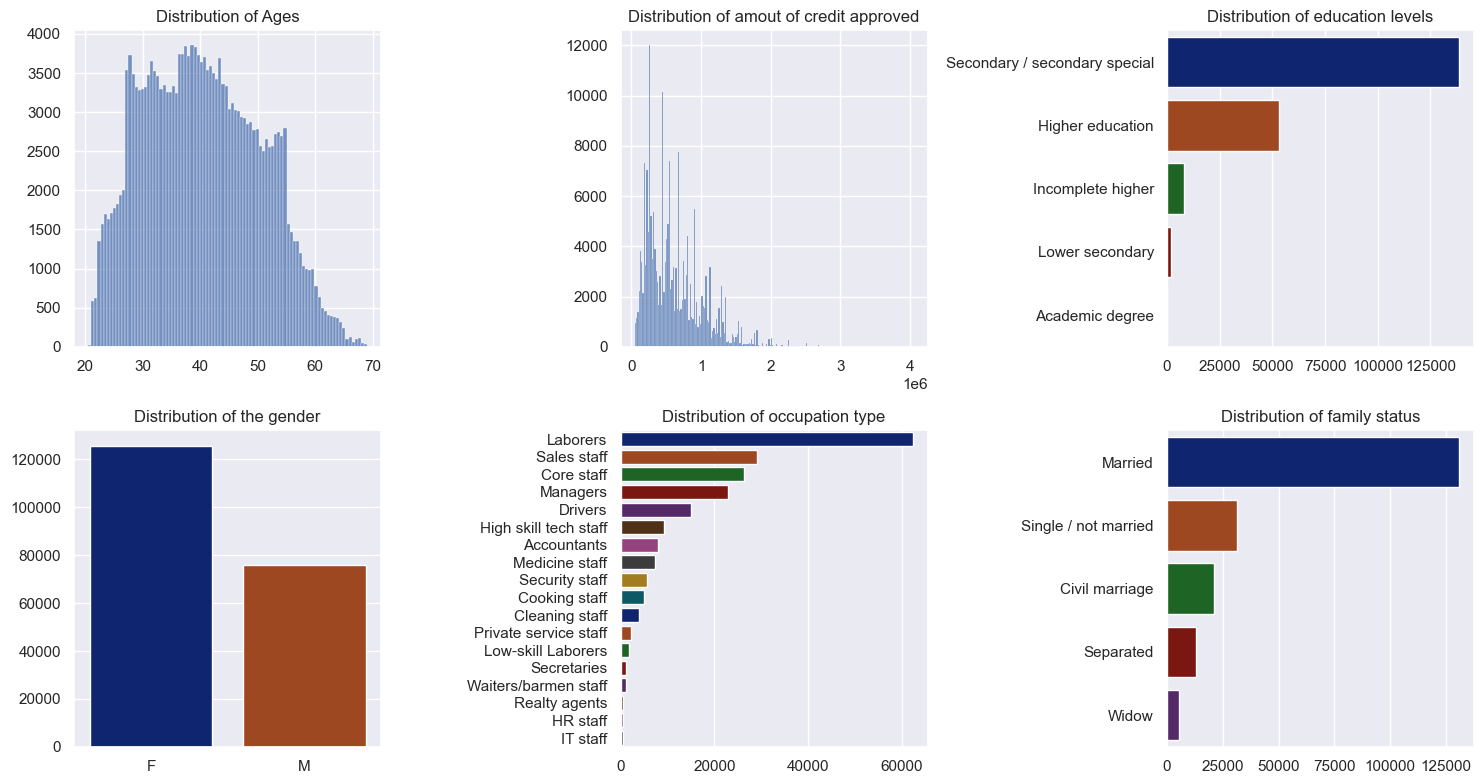

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)

# demographics_columns_hist = ['days_birth', 'cnt_children', 'amt_income_total', ]

# for i, column in enumerate(demographics_columns_hist):
#     sns.countplot(data=df_train, x=column, ax=axes[0, i], palette="dark")
#     axes[0, i].set_title(f"Distribution of {column}")
    
#     axes[0, i].tick_params(axis='x', rotation=45)


# demographics_columns = ['code_gender', 'name_family_status', 'name_education_type']

# for i, column in enumerate(demographics_columns):
#     sns.countplot(data=df_train, x=column, ax=axes[1, i], palette="dark")
#     axes[1, i].set_title(f"Distribution of {column}")
    
#     axes[1, i].tick_params(axis='x', rotation=45)


sns.histplot(data=df_eda, x='age', ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Ages")

sns.histplot(data=df_eda, x='amt_credit', ax=axes[0, 1])
axes[0, 1].set_title("Distribution of amout of credit approved")


education_order = df_eda.name_education_type.value_counts().sort_values(ascending=False).index
sns.countplot(data=df_eda, y='name_education_type', ax=axes[0, 2], palette="dark", order=education_order)
axes[0, 2].set_title(f"Distribution of education levels")
axes[0, 2].tick_params(axis='y', rotation=0)


gender_order = df_eda.code_gender.value_counts().sort_values(ascending=False).index
sns.countplot(data=df_eda, x='code_gender', ax=axes[1, 0], palette="dark", order=gender_order)
axes[1, 0].set_title(f"Distribution of the gender")


occupation_order = df_eda.occupation_type.value_counts().sort_values(ascending=False).index
sns.countplot(data=df_eda, y='occupation_type', ax=axes[1, 1], palette="dark", order=occupation_order)
axes[1, 1].set_title(f"Distribution of occupation type")
axes[1, 1].tick_params(axis='y', rotation=0)


status_order = df_eda.name_family_status.value_counts().sort_values(ascending=False).index
sns.countplot(data=df_eda, y='name_family_status', ax=axes[1, 2], palette="dark", order=status_order)
axes[1, 2].set_title(f"Distribution of family status")
axes[1, 2].tick_params(axis='y', rotation=0)




for i in range(2):
    for j in range(3):
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

From **clients' demographics** we could notice that:
> * The distribution of ages among the clients appears to follow a relatively normal distribution.
> * The distribution of the amount of credit approved highlights the presence of some outliers.
> * Most of the applicants finished only their secondary education.
> * Gender-wise, the dataset leans heavily toward female applicants.
> * Among the various listed occupations, laborers and cleaning staff stand out as the most common roles among the applicants.
> * Marital status appears as the most prevalent family status, signifying its significance due to the elevated proportion of applications linked to this category.

### How related applicant's info to the target
>   1. How does the clients' Demographics such as the age stages related to defaulting?
>   3. How does the type of work or housing sitiuation related to the approval?

In [52]:
repayers = df_eda.query('target == 0')
defaulters = df_eda.query('target == 1')

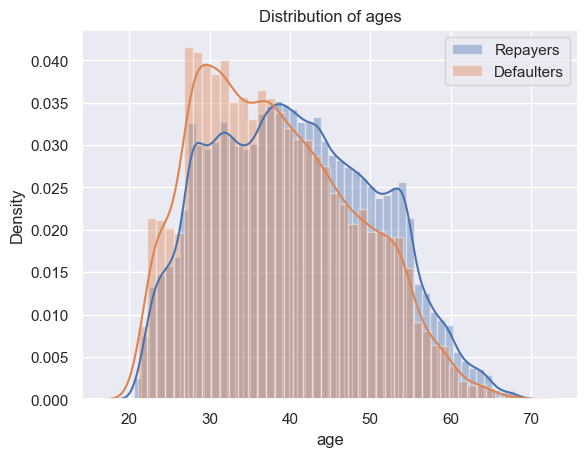

In [53]:
sns.distplot(repayers.age, label='Repayers');
sns.distplot(defaulters.age, label='Defaulters');
plt.title('Distribution of ages');
plt.legend();

> The older the applicant the higher chance to repay.

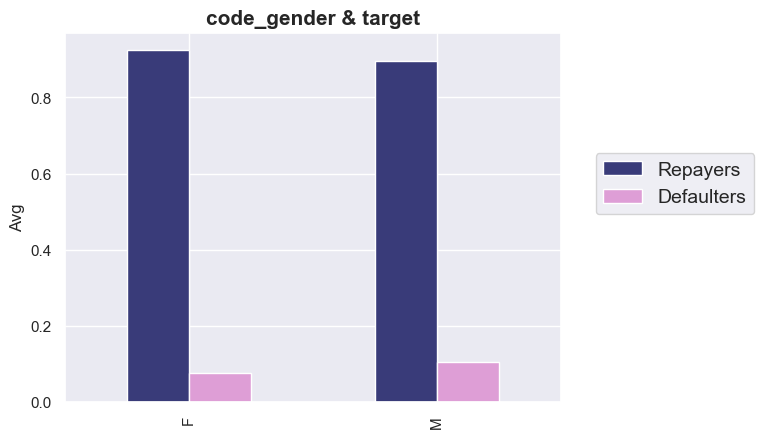

In [54]:
gender_propotions = get_propotions(df_eda, 'code_gender')

PlotPropotions(gender_propotions);

> Men are more likely to default more than women.

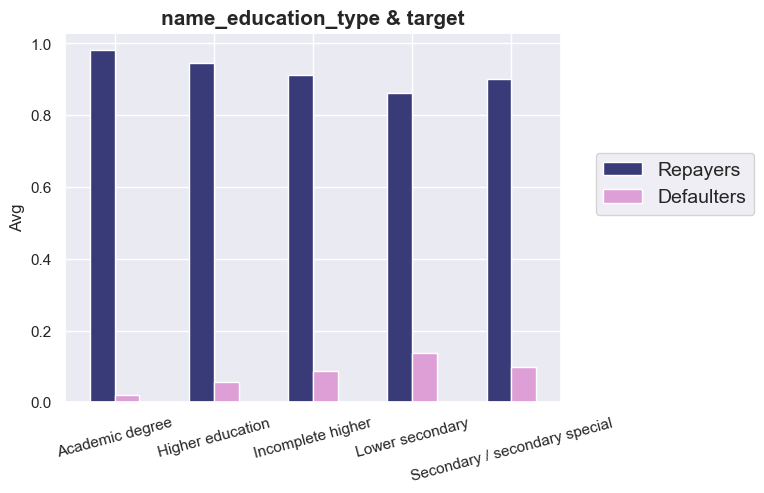

In [55]:
PlotPropotions(get_propotions(df_eda, 'name_education_type'), rot=15)

> The heighr the education level the lowr the default rate.

### Which most important documents that are necessary for the approval?


> **Note** We took 1 - > to indicates the absence of these documents.

In [56]:
documents_columns = df_eda.filter(like='dock_').columns.tolist()

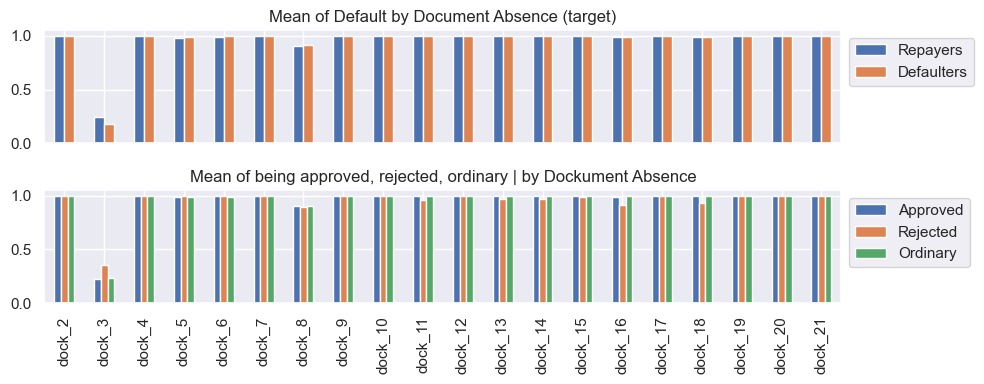

In [57]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharex=True)

# We took 1 - > to indicates the absence of these documents.
mean_of_default_of_each_dock = 1 - df_eda.groupby('target').mean()[documents_columns].T
mean_of_default_of_each_dock.plot(kind='bar', figsize=(10, 4), ax=axes[0]);

axes[0].set_title('Mean of Default by Document Absence (target)')
legend_labels_0 = ['Repayers', 'Defaulters']
axes[0].legend(legend_labels_0, loc='upper left', bbox_to_anchor=(1, 1))


mean_of_default_of_each_dock = 1 - df_eda.groupby('prev_status').mean()[documents_columns].T
mean_of_default_of_each_dock.plot(kind='bar', figsize=(10, 4), ax=axes[1]);


axes[1].set_title('Mean of being approved, rejected, ordinary | by Dockument Absence')
legend_labels_1 = ['Approved', 'Rejected', 'Ordinary']
axes[1].legend(legend_labels_1, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the subplot
plt.subplots_adjust(hspace=0.9)
plt.tight_layout()
plt.show()
#

The last chart provides insights into the relationship between the absence of documents provided by the applicant and their previous loan approval rates, as well as the impact on the target variable (default or not).

1. Loan Approval Rates:
   * For most documents, the absence or presence of the document does not significantly impact loan approval or rejection rates.

2. Default Rates:
   * Similarly, the absence or presence of most documents does not have a notable impact on whether the applicant will default on their loan.

Based on these findings, it is recommended to consider dropping all document-related columns except for dock_3 and dock_6. These two documents appear to have a more discernible influence on loan approval and default rates.


In [58]:
dock_columns_we_drop = [column for column in documents_columns if column not in ['dock_3', 'dock_6']]
df_train.drop(columns=dock_columns_we_drop, inplace=True)
df_test.drop(columns=dock_columns_we_drop, inplace=True)

### [ `CLEANING PART` ] Now, we need to convert all [string] columns into numeric values

> We didn't do that in the cleaning phase to make use of the actual names in analysis.

> We get the string columns and detailed number of unique values in them by:

```python
    cate_columns = df_train.select_dtypes(exclude=np.number).columns
    get_unique_values(df_train.loc[:, cate_columns])
```

> Or we could use:

In [59]:
df_train.describe(exclude=np.number)

name_contract_type code_gender flag_own_car flag_own_realty  \
count              201865      201865       201865          201865   
unique                  2           2            2               2   
top            Cash loans           F            N               Y   
freq               181132      125786       126387          136992   

       name_type_suite name_income_type            name_education_type  \
count           201865           201865                         201865   
unique               7                7                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            164985           127043                         138780   

       name_family_status  name_housing_type occupation_type  cnt_fam_members  \
count              201865             201865          201865         201865.0   
unique                  5                  6              18             16.0   
top               Married  House / apartment        Laborers              2.0   
freq               131185             176579           62368          98727.0   

       weekday_appr_process_start       organization_type  \
count                      201865                  201865   
unique                          7                      57   
top                       TUESDAY  Business Entity Type 3   
freq                        35184                   54436   

        amt_req_credit_bureau_hour  amt_req_credit_bureau_day  \
count                     201865.0                   201865.0   
unique                         5.0                        8.0   
top                            0.0                        0.0   
freq                      200786.0                   200913.0   

        amt_req_credit_bureau_week  amt_req_credit_bureau_mon  \
count                     201865.0                   201865.0   
unique                         9.0                       22.0   
top                            0.0                        0.0   
freq                      196313.0                   172125.0   

        amt_req_credit_bureau_qrt  amt_req_credit_bureau_year  
count                    201865.0                    201865.0  
unique                       10.0                        21.0  
top                           0.0                         0.0  
freq                     169334.0                     74747.0

> We notice the 2 features ['amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day'] have almost no variance.

> `One Hot Encoding`
> 
> columns with little number of unique values.

In [60]:
one_hot_encoding_imputation_columns = ['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 
'name_education_type', 'name_family_status', 'name_housing_type', 'weekday_appr_process_start']

for column_to_encode in one_hot_encoding_imputation_columns:
    # Creating dummy columns
    dummy_columns_train = pd.get_dummies(df_train[column_to_encode], prefix=column_to_encode, drop_first=True)
    dummy_columns_test = pd.get_dummies(df_test[column_to_encode], prefix=column_to_encode, drop_first=True)

    # Concatenating the dummy columns with the original DataFrames
    df_train = pd.concat([df_train, dummy_columns_train], axis=1)
    df_test = pd.concat([df_test, dummy_columns_test], axis=1)

    # Drop the original column as it has been encoded
    df_train.drop(columns=[column_to_encode], inplace=True)
    df_test.drop(columns=[column_to_encode], inplace=True)

> `Target Encoding`
> 
> columns with much unique values.

In [61]:
much_unique_values_columns = ['occupation_type', 'organization_type', 'cnt_fam_members']

target_encodings = {}
for column in much_unique_values_columns:
    target_encodings[column] = df_train.groupby(column).mean()['target']
    
for column in much_unique_values_columns:
    df_train[column] = df_train[column].map(target_encodings[column])
    df_test[column] = df_test[column].map(target_encodings[column])

In [62]:
print(f'There are {df_test.isna().sum().sum()} missing values generated in the test set.')

There are 1 missing values generated in the test set.


In [63]:
missing_rows = df_test.isna().any(axis=1)
df_test.drop(df_test.index[missing_rows], inplace=True)

print(f'Now, There are {df_test.isna().sum().sum()} missing values generated in the test set.')

Now, There are 0 missing values generated in the test set.


> Converting the datatype of some cleaned columns from object into float

In [64]:
object_to_float_columns = df_train.select_dtypes(exclude=np.number).columns.tolist()

df_train.loc[:, object_to_float_columns] = df_train.loc[:, object_to_float_columns].astype(float)
df_test.loc[:, object_to_float_columns] = df_test.loc[:, object_to_float_columns].astype(float)

#### Colleration between features with each others

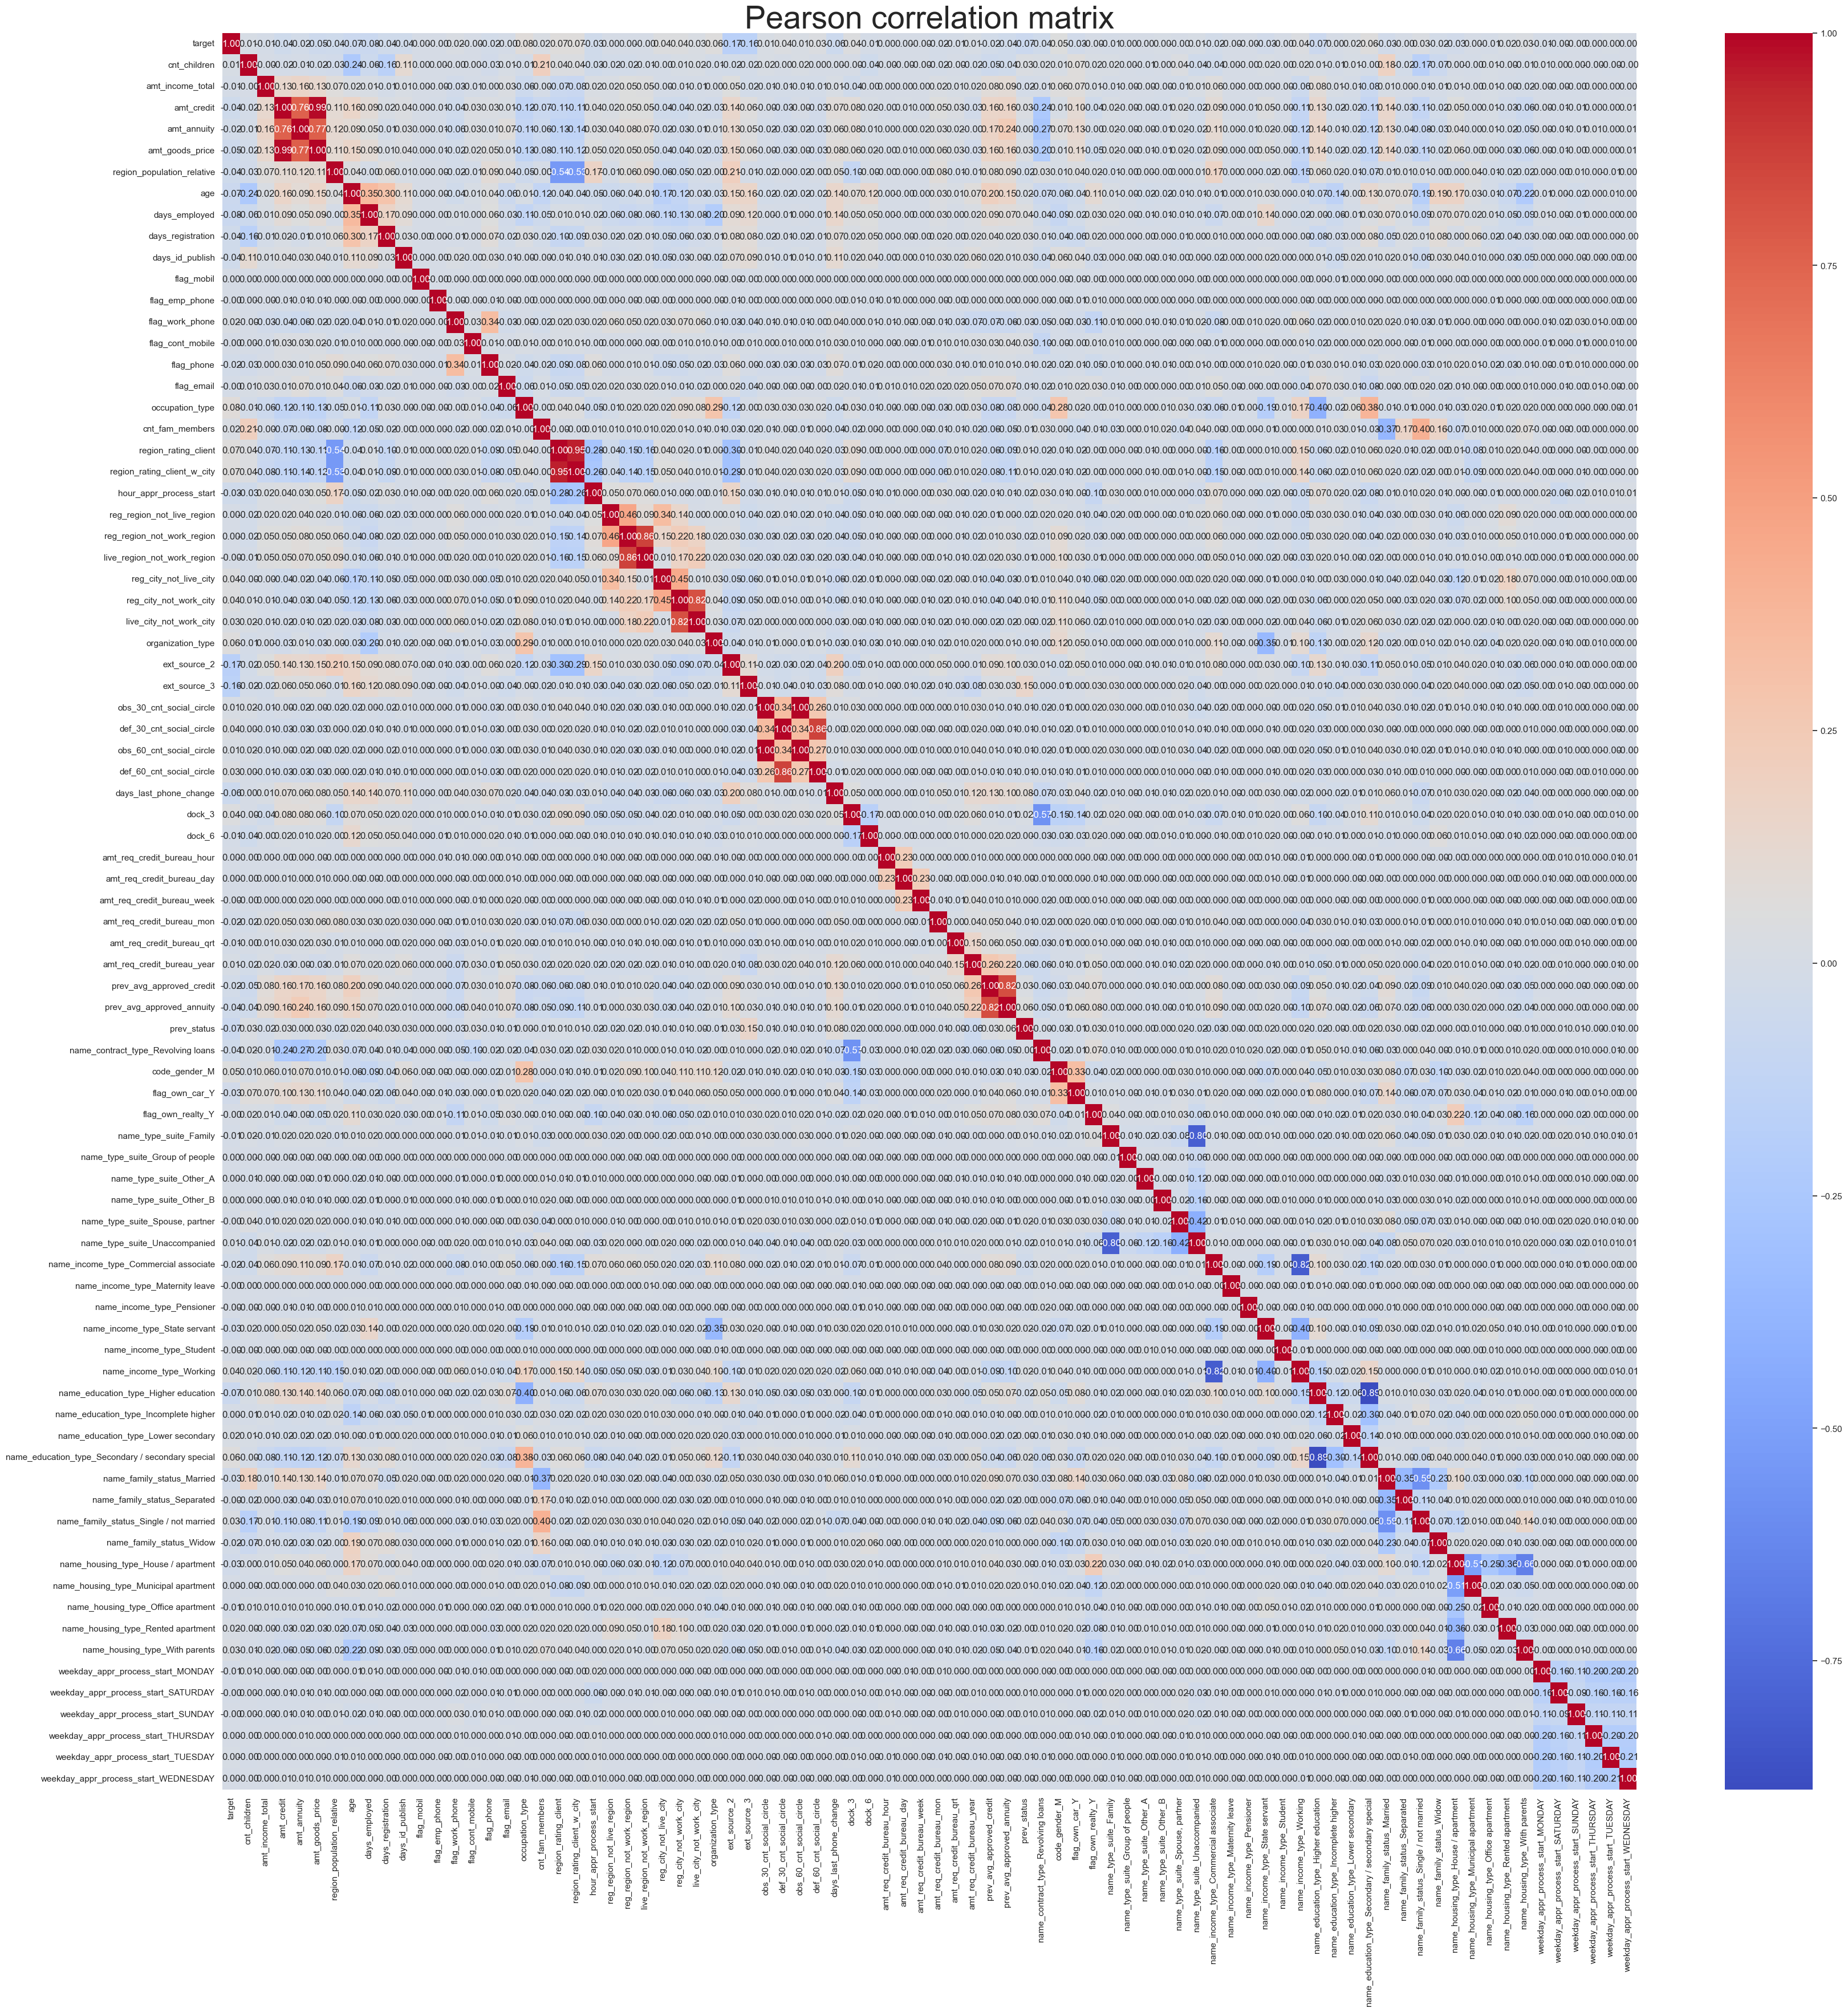

In [65]:
pearson_corr = df_train.corr()
mask = np.triu(np.ones_like(pearson_corr, dtype=bool)) # to get only the value once.

plt.figure(figsize=(40, 40));
sns.heatmap(pearson_corr, cmap="coolwarm", annot=True, fmt=".2f");
plt.title('Pearson correlation matrix', fontsize=40);

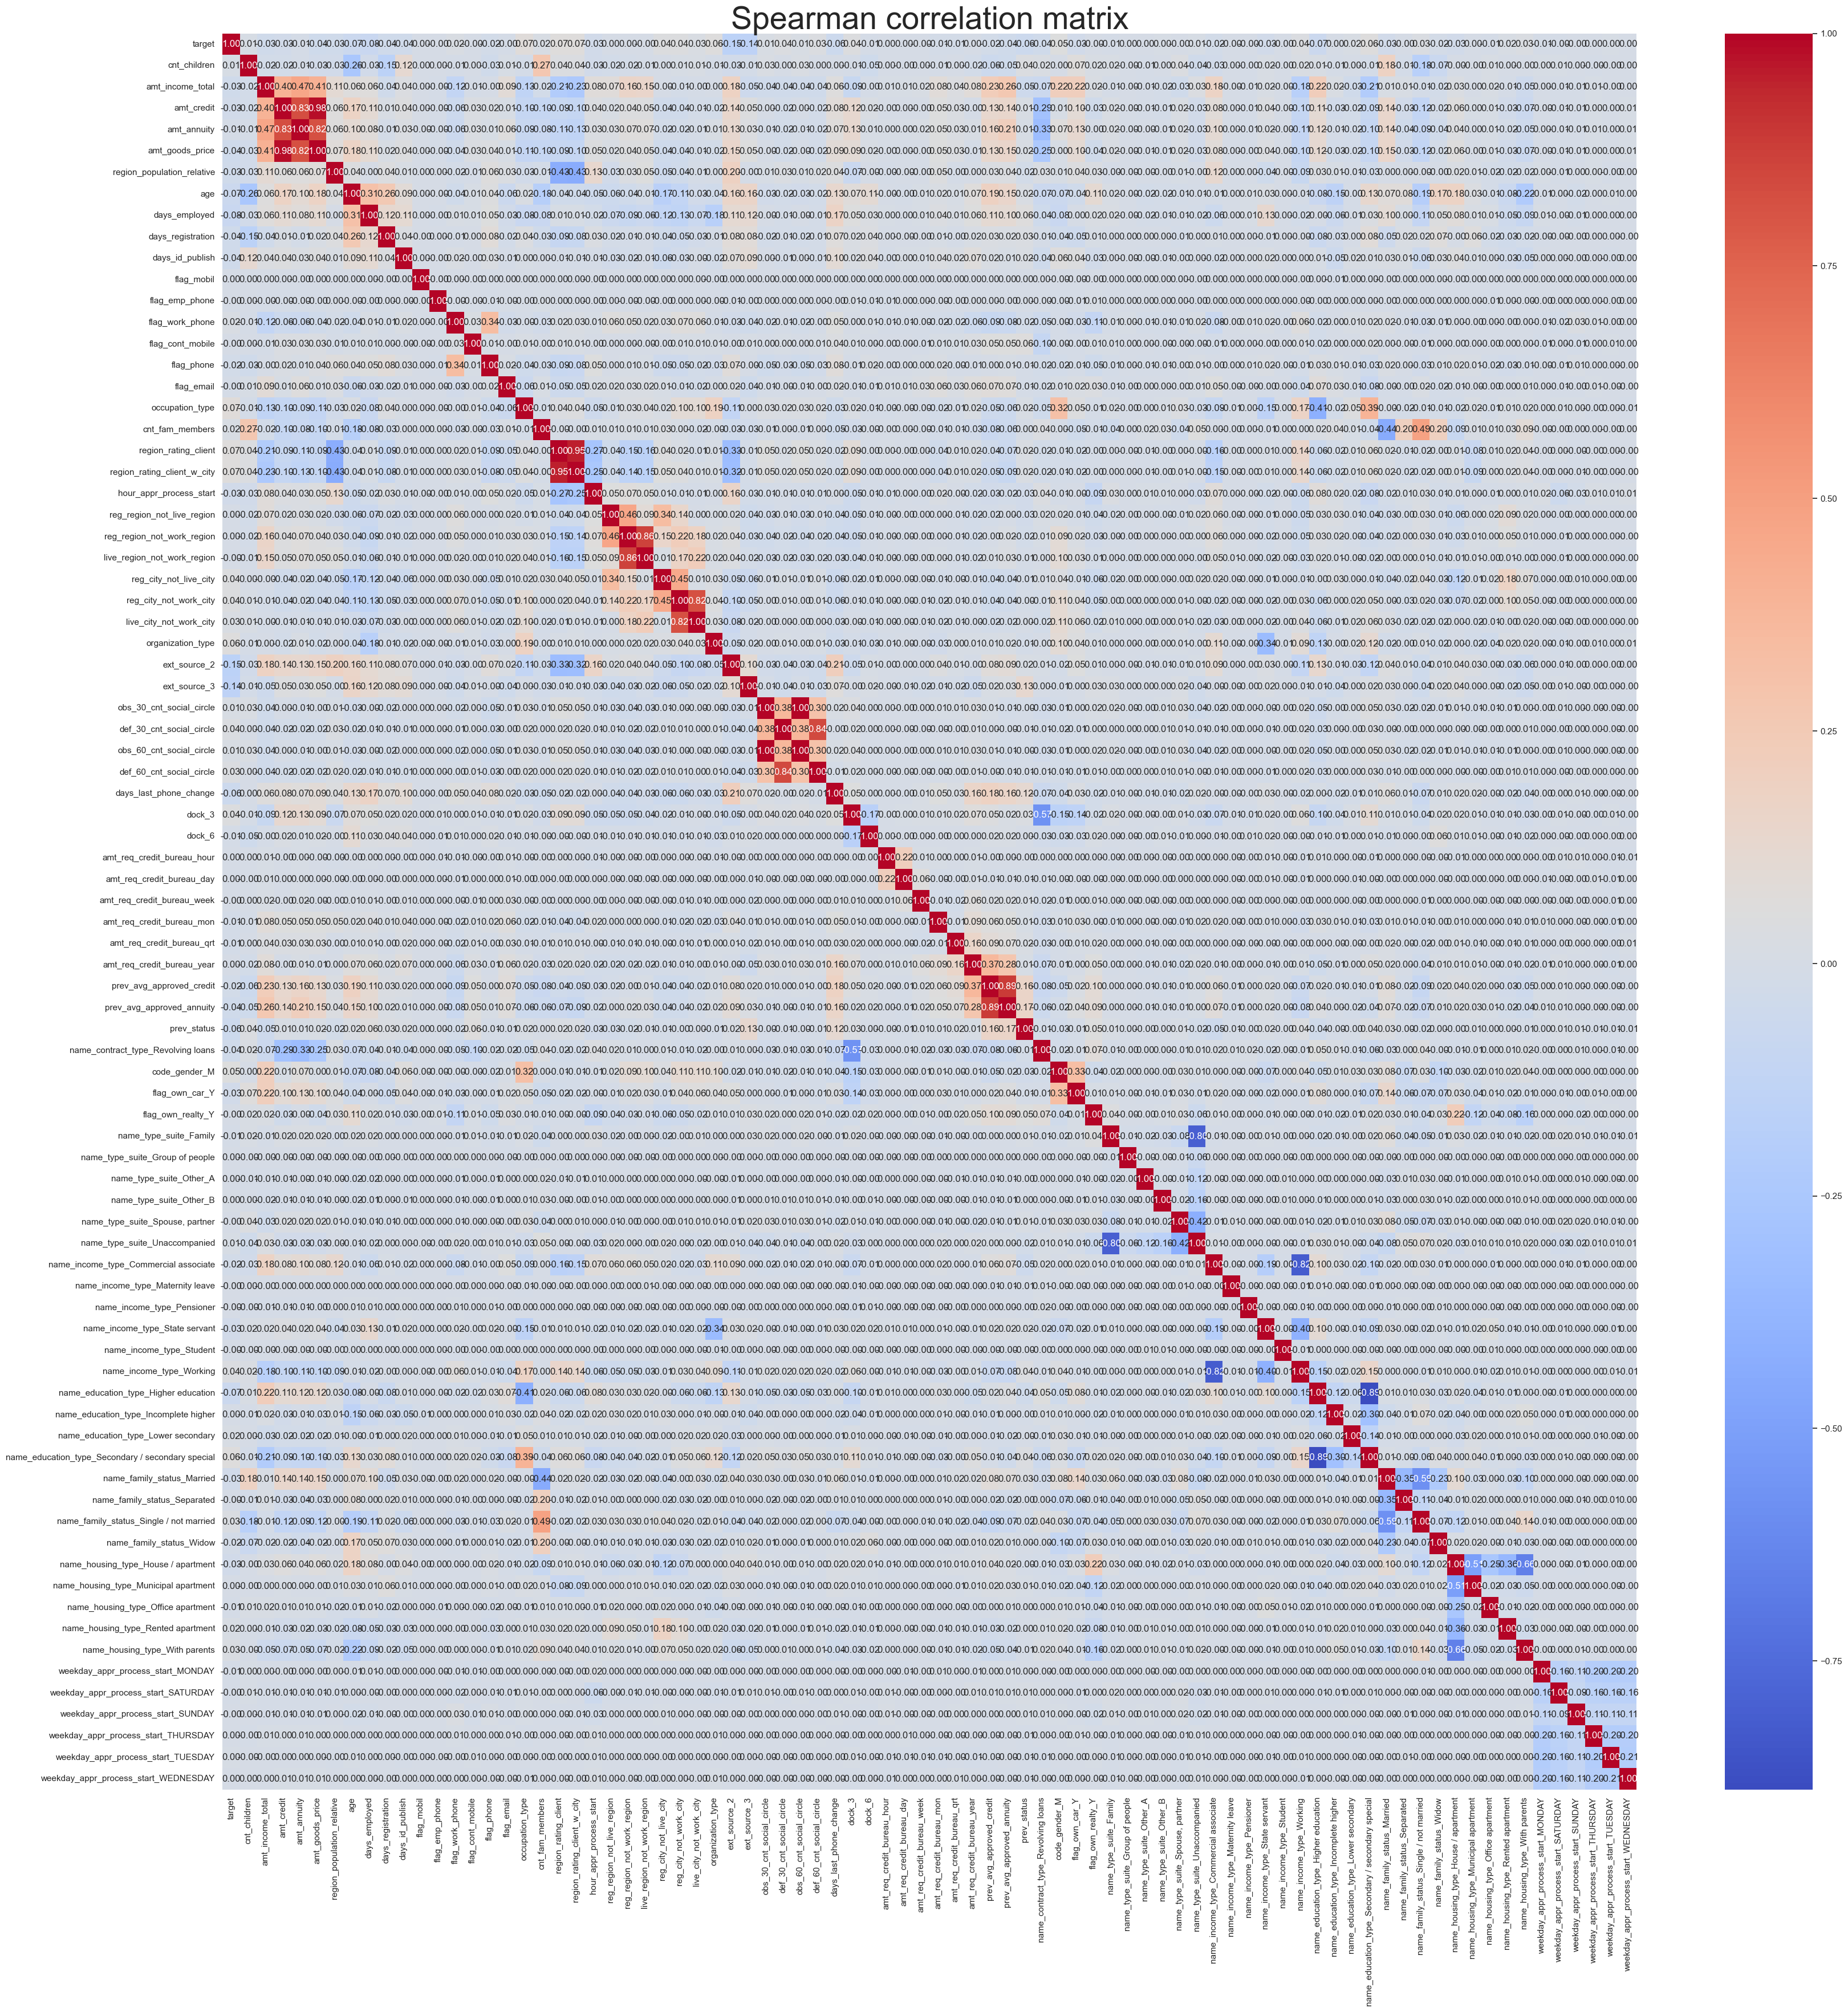

In [66]:
spearman_corr = df_train.corr(method='spearman')

plt.figure(figsize=(40, 40));
sns.heatmap(spearman_corr, cmap="coolwarm", annot=True, fmt=".2f");
plt.title('Spearman correlation matrix', fontsize=40);

> The result of `Pearson` and `Spearman` looks like the same, this indicates the relationships\
between the variables are linear. and there is no non-linear relations between features.
>
> There are many collerated features with each other.
> 
> There are many correlated `Combinations` of features, we will let them\
we could get better combination of them using PCA.
>
> using `VIF` to get most influnced variables with other ones.

In [67]:
tri_df = spearman_corr.mask(mask)

highly_correlated_columns_above_95 = [c for c in tri_df.columns if any(tri_df[c].abs() >  0.95)]
print(f'Highly correlated features with correlation coff > .95 are:\n')
for col in highly_correlated_columns_above_95:
    print(col)

Highly correlated features with correlation coff > .95 are:

amt_credit
region_rating_client
obs_30_cnt_social_circle


In [68]:
# Lets add a dummy feature to delete the features that have less importance than it.
df_train['dummy feature'] = np.random.randn(df_train.shape[0], 1)
df_test['dummy feature'] = np.random.randn(df_test.shape[0], 1)

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df['Features'] = df_train.columns
vif_df['VIF'] = [variance_inflation_factor(df_train.values, i) for i in range(df_train.shape[1])]

In [70]:
vif_df.sort_values(by='VIF', ascending=False).head()

Features           VIF
11                             flag_mobil  33660.741017
12                         flag_emp_phone  17424.541685
62               name_income_type_Working  13179.400896
57  name_income_type_Commercial associate   5941.327969
60         name_income_type_State servant   1818.255314

> There are huge VIF values and it is expected, as we got very **Linearly correlated**\
features from the confusion matrix.

### checking most important features

> **Note:** It is predicted to have bad values from random forest model here,\
due to the multicollinearity in our dataset, even if we use tree based models\
it will distribute the importance\
on highly correlated features.

> **So,** lets use voting from three models, with Recursive Feature Elimination.

In [71]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC

In [72]:
x_train = df_train.drop(columns='target')
normalized_x_train = StandardScaler().fit_transform(x_train)

In [73]:
lr_rfe = RFE(estimator=LogisticRegressionCV(), n_features_to_select=50, step=10, verbose=3)
lr_rfe.fit(normalized_x_train, df_train.target)

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.


RFE(estimator=LogisticRegressionCV(), n_features_to_select=50, step=10,
    verbose=3)

In [74]:
logistic_regression_ranking = lr_rfe.ranking_

In [75]:
rf_rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=50, step=10, verbose=3)
rf_rfe.fit(normalized_x_train, df_train.target)

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.


RFE(estimator=RandomForestClassifier(), n_features_to_select=50, step=10,
    verbose=3)

In [76]:
random_forest_ranking = rf_rfe.ranking_

In [77]:
svm_rfe = RFE(estimator=LinearSVC(), n_features_to_select=50, step=10, verbose=3)
svm_rfe.fit(df_train.drop(columns='target'), df_train.target)

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.


RFE(estimator=LinearSVC(), n_features_to_select=50, step=10, verbose=3)

In [78]:
svm_ranking = svm_rfe.ranking_

In [79]:
rankings_df = pd.DataFrame(data={'Features': df_train.drop(columns='target').columns,
                            'LogisticRegression_Ranking': logistic_regression_ranking,
                            'RandomForest_Ranking': random_forest_ranking,
                            'SVM_Ranking': svm_ranking})

rankings_df.set_index('Features', inplace=True)
rankings_df['Mean_Ranking'] = rankings_df.apply(lambda row: row.mean(), axis=1)
rankings_df.sort_values(by='Mean_Ranking', inplace=True)

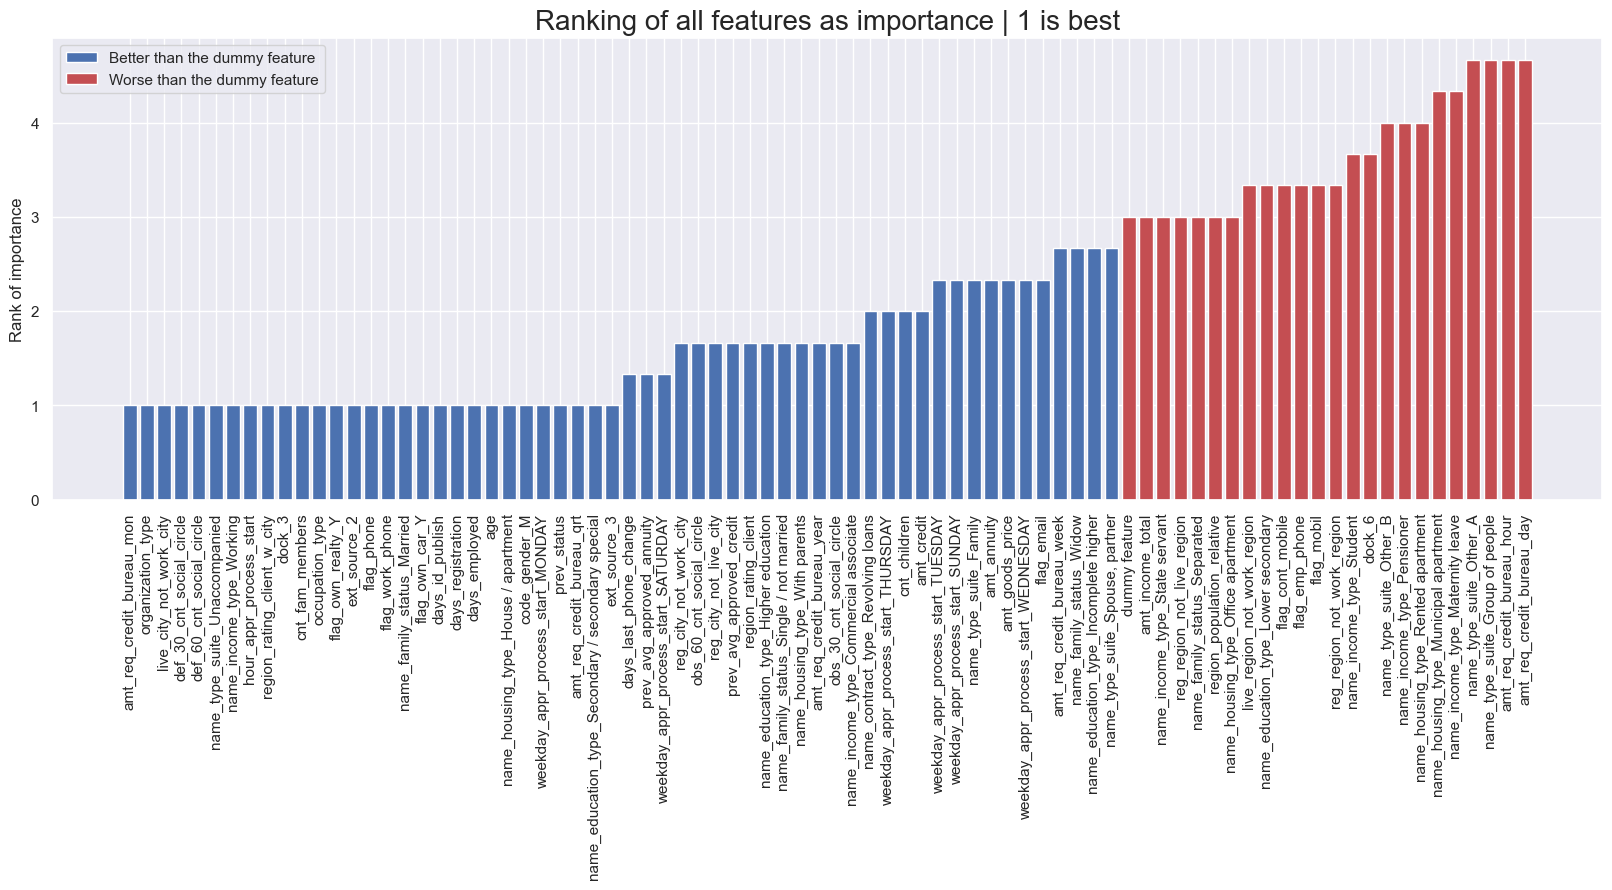

In [80]:
dummy_feature_index = rankings_df.index.get_loc('dummy feature')
plt.figure(figsize=(20, 6))

plt.bar(rankings_df.index[:dummy_feature_index], rankings_df['Mean_Ranking'].values[:dummy_feature_index], label='Better than the dummy feature', color='b')

# Plot bars for 'Features worest than the dummy feature'
plt.bar(rankings_df.index[dummy_feature_index:], rankings_df['Mean_Ranking'].values[dummy_feature_index:], label='Worse than the dummy feature', color='r')

plt.title('Ranking of all features as importance | 1 is best', fontsize=20);
plt.ylabel('Rank of importance');
plt.legend(['Favorable Features', 'Less Favorable Features'])

plt.legend()
plt.xticks(rotation=90)
plt.show()

> **Note:** If we see the ranking of the random forest model alone, it will give the dummy feature rank 1 !!!.
>
> **Note:** There are 2 features we aggregated from the previoud applications are in most important features 😉
>
> This is as expected as there is a big multicollinearity in the dataset.

In [81]:
df_status = pd.DataFrame()

df_status = rankings_df.reset_index()[['Features', 'Mean_Ranking']].merge(vif_df.query('Features != "target"'), on='Features').sort_values(by='Mean_Ranking', ascending=False)

In [82]:
importance_thershould_main = 2
impotance_threshould_second_chance = 2.5
vif_threshould = 10

included_features = df_status.query(f'Mean_Ranking < {importance_thershould_main} | (Mean_Ranking < {impotance_threshould_second_chance} & VIF < {vif_threshould})')

> * We will make use of the features with `High importance ranking` & `Low Vif`.
>
> * Lets detect the features that has:
>   * Importance Ranking < 2
>   * Importance Ranking < 2.5 but also VIF < 10

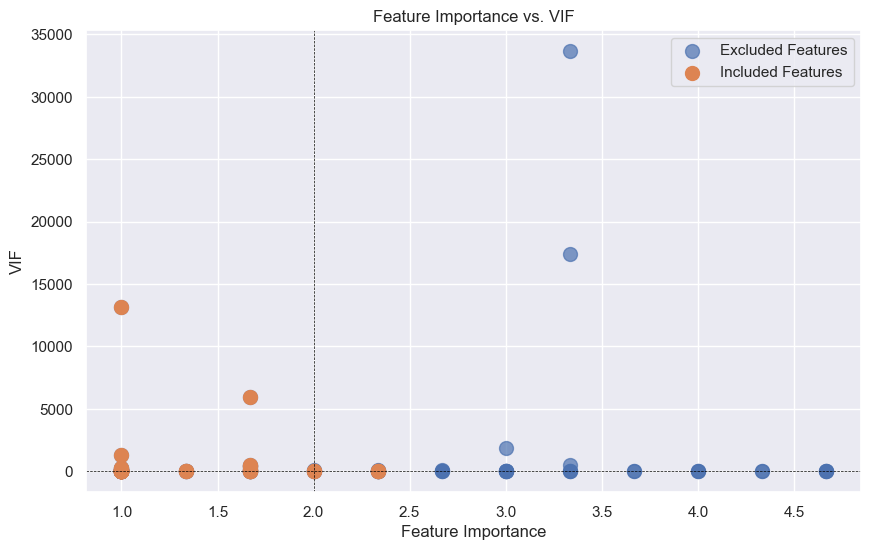

In [83]:
plt.figure(figsize=(10, 6))
plt.scatter(x = df_status['Mean_Ranking'],  y = df_status['VIF'],  marker='o', s=100, alpha=0.7, label='Excluded Features')
plt.scatter(x = included_features['Mean_Ranking'], y = included_features['VIF'], marker='o', s=100, label='Included Features')

plt.axvline(importance_thershould_main, linewidth=0.5, linestyle='--', c='black');
plt.axhline(vif_threshould, linewidth=0.5, linestyle='--', c='black');

plt.xlabel("Feature Importance")
plt.ylabel("VIF")
plt.title("Feature Importance vs. VIF")
plt.legend();

In [84]:
included_columns = included_features.query('Features != "dummy feature"').Features.tolist()
df_train.drop(columns='dummy feature', inplace=True)
df_test.drop(columns='dummy feature', inplace=True)


df_train_with_important_features = df_train.loc[:, included_columns + ['target']]
df_test_with_important_features = df_test.loc[:, included_columns + ['target']]

> Still having highly correlated features, here PCA will help.

In [85]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.99))])

x_train_pca = pipeline.fit_transform(df_train_with_important_features.drop(columns='target'))
x_test_pca  = pipeline.transform(df_test_with_important_features.drop(columns='target'))

### Conclusion

In [86]:
print(f'There are only {x_train_pca.shape[1] - 1} promising features, we got them from our EDA')

There are only 35 promising features, we got them from our EDA


## Modeling

In [87]:
x_train = x_train_pca
y_train = df_train.target

x_test = x_test_pca
y_test = df_test.target

#### As anomaly detection problem

In [88]:
x_train_normal = x_train[y_train == 0]

In [89]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.081, n_estimators=1000, random_state=42)
model.fit(x_train_normal)

IsolationForest(contamination=0.081, n_estimators=1000, random_state=42)

In [90]:
y_pred = model.predict(x_test)

In [91]:
y_pred_binary = (y_pred == -1).astype(int)

confusion_matrix(y_test, y_pred_binary)

array([[42120,  3806],
       [ 3945,   400]], dtype=int64)

### As a classification problem

> Handling the impalanced dataset problem

In [92]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train_pca, y_train)

> We need some of tuning the model to handel the impalanced data.

In [93]:
class_weights = len(y_train) / (2 * np.bincount(y_train))
class_weights

array([0.54743051, 5.77086907])

In [148]:
# param_dist = {
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': np.logspace(-3, 0, 4),
#     'n_estimators': [50, 100, 300, 500, 700, 900, 1000],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 1, 5],
#     'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization term
#     'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 regularization term
#     'scale_pos_weight': [9, 9.5, 10],  # Class weight for positive class
# }


# xgb_classifier = XGBClassifier(
#     objective='binary:logistic',
#     gpu_id=0,
#     random_state=42
# )

# # Create RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     xgb_classifier,
#     param_distributions=param_dist,
#     n_iter=50,
#     scoring='recall',
#     cv=3,
#     verbose=1,
#     n_jobs = -1,
#     random_state=42,
# )

# # Fit RandomizedSearchCV on the original dataset not with SMOTE
# random_search.fit(x_train_pca, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=0,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=No...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0, 0.1, 0.5, 1.0],
                                        'scale_pos_weight': [9, 9.5, 10],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

In [151]:
random_search.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 10,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 5,
 'colsample_bytree': 1.0}

> After fine tuning we got that best parameters are:

> 
```python
{'subsample': 0.8,
 'scale_pos_weight': 10,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 5,
 'colsample_bytree': 1.0}
```

> Notice, we will train the model with the original dataset without PCA.
> 
> This is because XGBoost handels the multicollinearity [tested].

In [94]:
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric= 'logloss',
    subsample=0.8,
    scale_pos_weight=10,
    reg_lambda= 1.0,
    reg_alpha= 0.5,
    n_estimators= 100,
    max_depth=3,
    learning_rate=0.1,
    gamma=5,
    colsample_bytree=1.0,
    random_state=42,
    gpu_id=0,
    n_jobs = -1
)

x_train_important_features = df_train_with_important_features.drop(columns='target')
x_test_important_features = df_test_with_important_features.drop(columns='target')

# Fit the model
xgb_classifier.fit(x_train_important_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [95]:
# Make predictions
y_pred_prob = xgb_classifier.predict_proba(x_test_important_features)[:, 1]

threshold = 0.3 # You can adjust this threshold
y_pred = (y_pred_prob > threshold).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

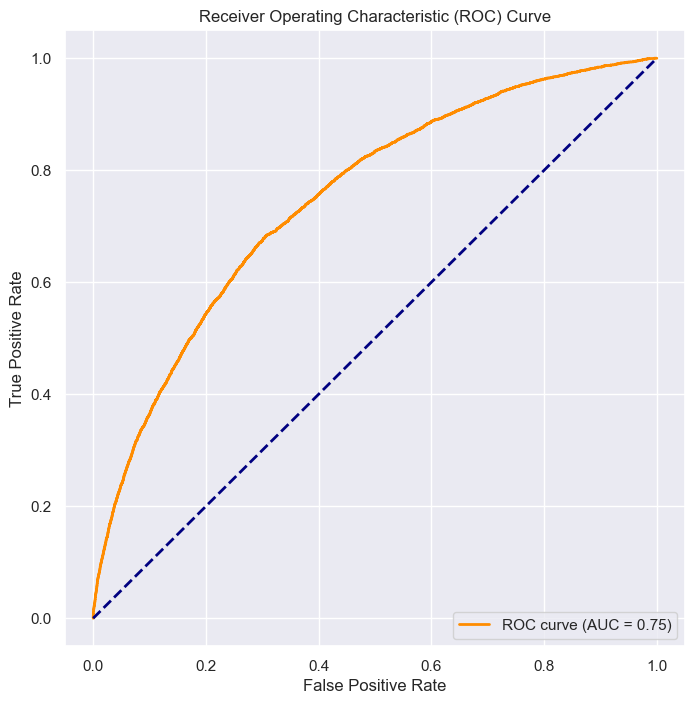

In [96]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [97]:
recall = recall_score(y_test, y_pred)
print("Recall: {:.2f}".format(recall))

Recall: 0.91


In [101]:
!code .

In [98]:
import pickle

# Save to file in the current working directory
pkl_filename = "xgboost_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [99]:
df_train.to_csv('cleaned_training_data.csv')
df_test.to_csv('cleaned_test_data.csv')